# PyThia

PyThia performs video prediction for simple physical systems:
given initial video frames, what will a future video frame look like?

## Technical preliminaries

We install the `pythia` package and import it.
We also import other libraries, or tools from other libraries, which will be of use.

In [ ]:
pip install git+https://github.com/aremondtiedrez/pythia.git

In [2]:
from IPython.display import HTML

import pythia

## Getting familiar with the data

The objective of PyThia is, humbly, to predict the future.
That being said, it does so in a very restricted context.

The only data that PyThia models ever see consists in a single ball
bouncing around a box. More precisely, the data consists in snapshots,
evenly spaced in time, of that ball's position.

We must make an important distinction here: PyThia models
are fed *raw image data*. They are not told what the exact position of the ball is, or what its exact velocity is. They are certainly not told anything about the laws of physics or the equations governing elastic collisions between
a ball and a box's walls. These are all things that the models will infer,
to the extend that it helps them fulfill their prediction task.

The task that PyThia models handle is then the following:
given a series of snapshots, can we predict the image that will be captured
a few moments in the future?

In this notebook, there are two easy ways to get your hands on data.
1. Load the demonstration data.
2. Generate (randomly) your own data.

In [3]:
# Load the demonstration data
snapshot_timesteps, positions, velocities, images = pythia.demo.load_data()

# Generate your own data
# (As the number of samples increases, this can become a somewhat lengthy process)
snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10)

Whichever way you got your hands on data, you can take a look at individual samples in the same way.

In [4]:
# Remember: each sample is a sequence of images.
# To see what they look like, in sequence, you can create and
# display a short animation.
sample = images[0]
animation = pythia.visualization.create_animation(sample, display_walls=True)
HTML(animation.to_jshtml())

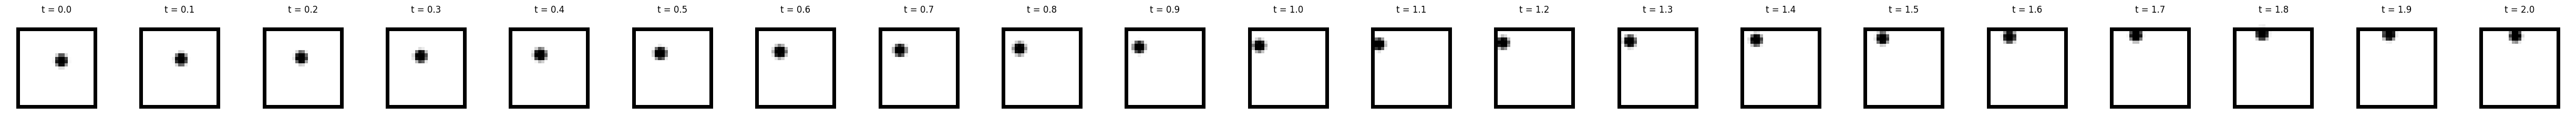

Initial velocity:    [-109.81   47.94]
Position at t = 0.0: [115.2  227.86]
Position at t = 0.1: [115.2  227.86]
Position at t = 0.2: [115.2  227.86]
Position at t = 0.3: [115.2  227.86]
Position at t = 0.4: [115.2  227.86]
Position at t = 0.5: [115.2  227.86]
Position at t = 0.6: [115.2  227.86]
Position at t = 0.7: [115.2  227.86]
Position at t = 0.8: [115.2  227.86]
Position at t = 0.9: [115.2  227.86]
Position at t = 1.0: [115.2  227.86]
Position at t = 1.1: [115.2  227.86]
Position at t = 1.2: [115.2  227.86]
Position at t = 1.3: [115.2  227.86]
Position at t = 1.4: [115.2  227.86]
Position at t = 1.5: [115.2  227.86]
Position at t = 1.6: [115.2  227.86]
Position at t = 1.7: [115.2  227.86]
Position at t = 1.8: [115.2  227.86]
Position at t = 1.9: [115.2  227.86]
Position at t = 2.0: [115.2  227.86]


In [7]:
# You can also visualize that same sample by plotting all of its images side-by-side
# (This will also show the initial velocity and the positions of the ball at each time
# when an image has been captured. Remember: the PyThia models never see this information.
# Nonetheless, it can sometimes can in handy to have access to it.)
pythia.visualization.inspect_sample(0, snapshot_timesteps, positions, velocities, images, display_walls=True)